In [ ]:

!pip install tensorflow numpy matplotlib faiss-cpu

In [ ]:
import os, requests, tempfile
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
import faiss


In [ ]:
import os, requests

os.makedirs("ms_data", exist_ok=True)

# There are 25 patients in open_ms_data (cross-sectional/coregistered)
num_patients = 30
files = []

for i in range(1, num_patients+1):
    pid = f"patient{i:02d}"
    url = f"https://github.com/muschellij2/open_ms_data/raw/master/cross_sectional/coregistered/{pid}/FLAIR.nii.gz"
    fname = f"ms_data/{pid}_FLAIR.nii.gz"

    try:
        r = requests.get(url)
        if r.status_code == 200:
            with open(fname, "wb") as f:
                f.write(r.content)
            files.append(fname)
            print(f"✅ Downloaded {fname}")
        else:
            print(f"❌ Missing file for {pid}")
    except Exception as e:
        print(f"⚠️ Error for {pid}: {e}")

print("\nTotal downloaded files:", len(files))


✅ Downloaded ms_data/patient01_FLAIR.nii.gz
✅ Downloaded ms_data/patient02_FLAIR.nii.gz
✅ Downloaded ms_data/patient03_FLAIR.nii.gz
✅ Downloaded ms_data/patient04_FLAIR.nii.gz
✅ Downloaded ms_data/patient05_FLAIR.nii.gz
✅ Downloaded ms_data/patient06_FLAIR.nii.gz
✅ Downloaded ms_data/patient07_FLAIR.nii.gz
✅ Downloaded ms_data/patient08_FLAIR.nii.gz
✅ Downloaded ms_data/patient09_FLAIR.nii.gz
✅ Downloaded ms_data/patient10_FLAIR.nii.gz
✅ Downloaded ms_data/patient11_FLAIR.nii.gz
✅ Downloaded ms_data/patient12_FLAIR.nii.gz
✅ Downloaded ms_data/patient13_FLAIR.nii.gz
✅ Downloaded ms_data/patient14_FLAIR.nii.gz
✅ Downloaded ms_data/patient15_FLAIR.nii.gz
✅ Downloaded ms_data/patient16_FLAIR.nii.gz
✅ Downloaded ms_data/patient17_FLAIR.nii.gz
✅ Downloaded ms_data/patient18_FLAIR.nii.gz
✅ Downloaded ms_data/patient19_FLAIR.nii.gz
✅ Downloaded ms_data/patient20_FLAIR.nii.gz
✅ Downloaded ms_data/patient21_FLAIR.nii.gz
✅ Downloaded ms_data/patient22_FLAIR.nii.gz
✅ Downloaded ms_data/patient23_F

In [ ]:
import nibabel as nib
import numpy as np

shapes = []
intensity_means = []
intensity_stds = []

for f in files:
    img = nib.load(f)
    data = img.get_fdata()
    shapes.append(data.shape)
    intensity_means.append(np.mean(data))
    intensity_stds.append(np.std(data))

print("Number of patients:", len(files))
print("Unique shapes:", set(shapes))
print("Average mean intensity:", np.mean(intensity_means))
print("Average std intensity:", np.mean(intensity_stds))


Number of patients: 30
Unique shapes: {(176, 512, 512), (192, 512, 512)}
Average mean intensity: 21.95308379801837
Average std intensity: 44.155432330548024


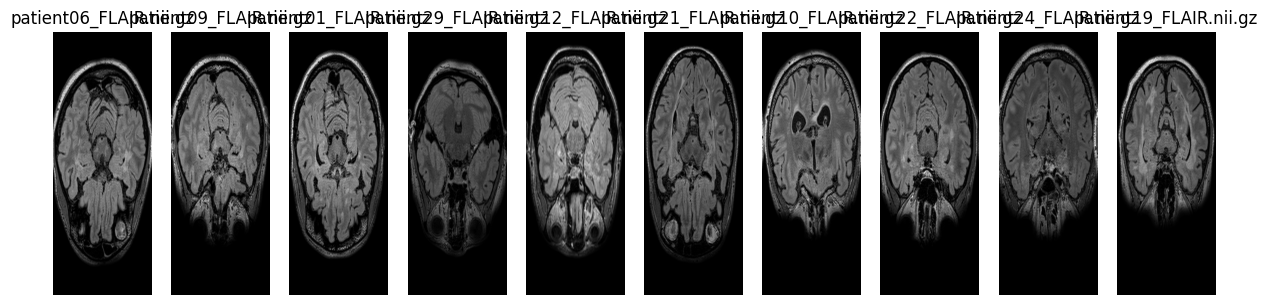

In [ ]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(15,6))
for i, f in enumerate(random.sample(files, 10)):
    img = nib.load(f)
    data = img.get_fdata()
    mid = data.shape[2] // 2
    slice_img = data[:, :, mid]

    plt.subplot(1,10,i+1)
    plt.imshow(slice_img.T, cmap="gray", origin="lower")
    plt.title(f.split('/')[-1])
    plt.axis("off")
plt.show()


         Patient  Slices
count  30.000000    30.0
mean   15.500000   512.0
std     8.803408     0.0
min     1.000000   512.0
25%     8.250000   512.0
50%    15.500000   512.0
75%    22.750000   512.0
max    30.000000   512.0


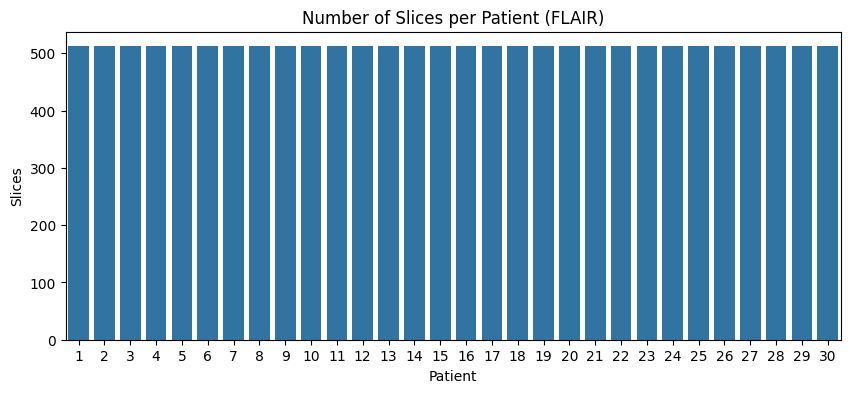

In [ ]:
slice_counts = [nib.load(f).get_fdata().shape[2] for f in files]

import pandas as pd
import seaborn as sns

df = pd.DataFrame({"Patient": range(1, len(files)+1), "Slices": slice_counts})
print(df.describe())

plt.figure(figsize=(10,4))
sns.barplot(x="Patient", y="Slices", data=df)
plt.title("Number of Slices per Patient (FLAIR)")
plt.show()



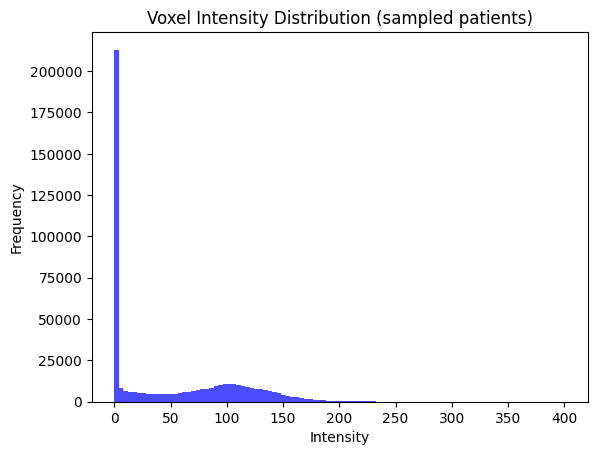

In [ ]:
import random

intensity_samples = []
for f in random.sample(files, 5):   # only 5 patients
    img = nib.load(f).get_fdata()
    mid = img.shape[2] // 2
    slice_img = img[:, :, mid]
    intensity_samples.extend(slice_img.flatten())

plt.hist(np.clip(intensity_samples, 0, 3000), bins=100, color='blue', alpha=0.7)
plt.title("Voxel Intensity Distribution (sampled patients)")
plt.xlabel("Intensity")
plt.ylabel("Frequency")
plt.show()


In [ ]:
import tensorflow as tf

img_size = (299,299)

def preprocess_slice(slice_img):
    # Normalize [0,1]
    slice_img = (slice_img - np.min(slice_img)) / (np.max(slice_img) - np.min(slice_img) + 1e-8)
    # Resize & convert to RGB
    slice_img = tf.image.resize(slice_img[..., np.newaxis], img_size)
    slice_img = tf.image.grayscale_to_rgb(slice_img)
    return slice_img.numpy()

all_images = []
labels = []

for pid, f in enumerate(files, start=1):
    img = nib.load(f).get_fdata()
    mid = img.shape[2] // 2
    # take 10 slices around the middle
    for i in range(mid-5, mid+5):
        slice_img = preprocess_slice(img[:, :, i])
        all_images.append(slice_img)
        labels.append(pid)   # label = patient ID

all_images = np.array(all_images)
labels = np.array(labels)

print("Dataset shape:", all_images.shape)
print("Number of patients:", len(set(labels)))


Dataset shape: (300, 299, 299, 3)
Number of patients: 30


In [ ]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = InceptionV3(weights="imagenet", include_top=False, input_shape=(299,299,3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="gelu")(x)
x = Dropout(0.2)(x)
x = Dense(256, activation="gelu")(x)
x = Dropout(0.2)(x)
features = Dense(32, activation="linear")(x)

model = Model(inputs=base_model.input, outputs=features)

for layer in base_model.layers:
    layer.trainable = False


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
features_all = model.predict(all_images, batch_size=8, verbose=1)
print("Feature matrix shape:", features_all.shape)


38/38 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step
Feature matrix shape: (300, 32)


In [ ]:
import faiss

d = features_all.shape[1]
index = faiss.IndexFlatL2(d)   # Euclidean distance
index.add(features_all.astype("float32"))


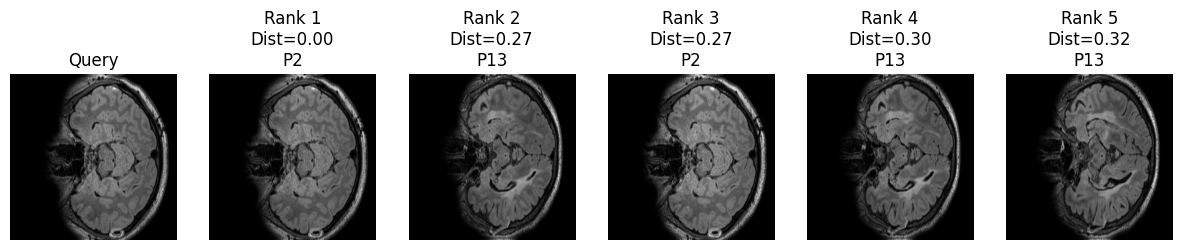

In [ ]:
import matplotlib.pyplot as plt

def show_results(query_idx=0, k=5):
    query_vector = features_all[query_idx:query_idx+1].astype("float32")
    D, I = index.search(query_vector, k)

    plt.figure(figsize=(15,3))
    # Query
    plt.subplot(1,k+1,1)
    plt.imshow(all_images[query_idx])
    plt.title("Query")
    plt.axis("off")

    # Retrieved images
    for i, idx in enumerate(I[0]):
        plt.subplot(1,k+1,i+2)
        plt.imshow(all_images[idx])
        plt.title(f"Rank {i+1}\nDist={D[0][i]:.2f}\nP{labels[idx]}")
        plt.axis("off")
    plt.show()

show_results(query_idx=10, k=5)
